Found 1600 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Class Names: ['cyclone', 'earthquake', 'flood', 'wildfire']


2025-03-24 22:47:07.311573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 49 of 1000
2025-03-24 22:47:07.415955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


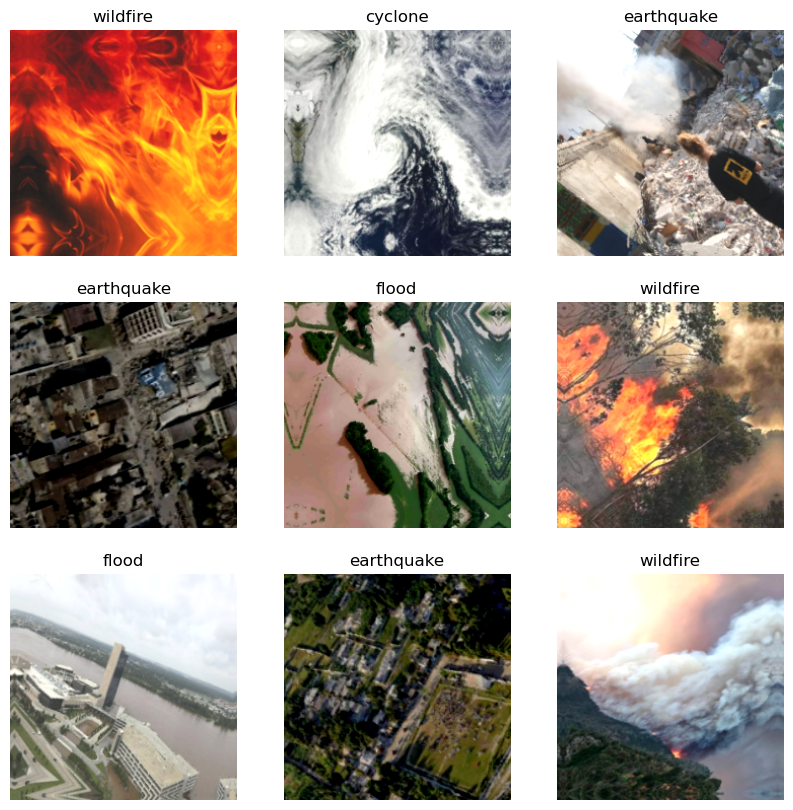

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Path to dataset
dataset_path = "/Users/rohanshenoy/Desktop/DisasterModel"  # Change to your dataset path
import tensorflow as tf
import os

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Dataset path
# Load train, validation, and test datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path + "/train",
    image_size=img_size,
    batch_size=batch_size
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path + "/validation",
    image_size=img_size,
    batch_size=batch_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path + "/test",
    image_size=img_size,
    batch_size=batch_size
)

# Define Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Flip images randomly
    tf.keras.layers.RandomRotation(0.2),  # Rotate images randomly
    tf.keras.layers.RandomZoom(0.2),  # Zoom in on images randomly
    tf.keras.layers.RandomBrightness(0.2),  # Adjust brightness
    tf.keras.layers.RandomContrast(0.2)  # Adjust contrast
])

# Function to Apply Augmentation
def augment_data(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Ensure float32 type
    image = data_augmentation(image, training=True)  # Apply augmentation
    return image, label

# Apply Augmentation to Training Set
train_dataset = train_dataset.map(augment_data)

# Normalize Validation and Test Sets
def normalize(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1]
    return image, label

val_dataset = val_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# Prefetch to improve training speed
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Get class names
class_names = sorted(os.listdir(dataset_path + "/train"))
print("Class Names:", class_names)


# Show sample images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


# checking for class imbalance

In [50]:
import os

# Path to dataset
dataset_path = "/Users/rohanshenoy/Desktop/DisasterModel"  # Change to your dataset path

# Count images per class
def count_images_in_folders(base_path):
    class_counts = {}
    for category in os.listdir(base_path):
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):  # Ensure it's a folder
            num_images = len(os.listdir(category_path))
            class_counts[category] = num_images
    return class_counts

# Print class distribution
print("Training Set:", count_images_in_folders(dataset_path + "/train"))
print("Validation Set:", count_images_in_folders(dataset_path + "/validation"))
print("Test Set:", count_images_in_folders(dataset_path + "/test"))


Training Set: {'flood': 400, 'wildfire': 400, 'earthquake': 400, 'cyclone': 400}
Validation Set: {'flood': 100, 'wildfire': 100, 'earthquake': 100, 'cyclone': 100}
Test Set: {'flood': 100, 'wildfire': 100, 'earthquake': 100, 'cyclone': 100}


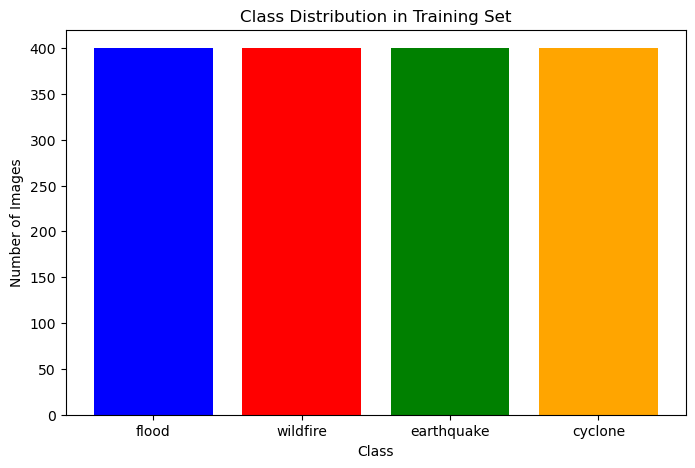

In [51]:
import matplotlib.pyplot as plt

# Count images per class
train_counts = count_images_in_folders(dataset_path + "/train")

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(train_counts.keys(), train_counts.values(), color=['blue', 'red', 'green', 'orange'])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.show()


# architechture

In [61]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models

# Load EfficientNetB3 with pre-trained ImageNet weights
base_model = EfficientNetB3(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = True  # Allow training

# Freeze only the first 100 layers
for layer in base_model.layers[:100]:  
    layer.trainable = False  

# Define the new model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(4, activation="softmax")  # 4 disaster classes
])

# Compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),  
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Train
class_weight = {0: 1.0, 1: 1.0, 2: 0.8, 3: 1.0}


history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)


Epoch 1/20


2025-03-25 18:33:27.748425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 23 of 1000
2025-03-25 18:33:35.138150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 287s 5s/step - loss: 1.4770 - accuracy: 0.2575 - val_loss: 1.4385 - val_accuracy: 0.2725
Epoch 2/20


2025-03-25 18:37:59.666101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-03-25 18:38:10.085971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 240s 4s/step - loss: 1.4418 - accuracy: 0.2713 - val_loss: 1.4111 - val_accuracy: 0.3000
Epoch 3/20


2025-03-25 18:42:00.033695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 26 of 1000
2025-03-25 18:42:05.754933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 248s 5s/step - loss: 1.4132 - accuracy: 0.3144 - val_loss: 1.3861 - val_accuracy: 0.3075
Epoch 4/20


2025-03-25 18:46:08.913768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-03-25 18:46:15.916943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 249s 5s/step - loss: 1.4108 - accuracy: 0.3044 - val_loss: 1.3592 - val_accuracy: 0.3375
Epoch 5/20


2025-03-25 18:50:17.552494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 23 of 1000
2025-03-25 18:50:25.947450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 287s 5s/step - loss: 1.3912 - accuracy: 0.3056 - val_loss: 1.3333 - val_accuracy: 0.3750
Epoch 6/20


2025-03-25 18:55:05.575366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 8 of 1000
2025-03-25 18:55:25.019067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 40 of 1000
2025-03-25 18:55:27.004956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 285s 5s/step - loss: 1.3646 - accuracy: 0.3306 - val_loss: 1.3075 - val_accuracy: 0.4150
Epoch 7/20


2025-03-25 18:59:49.372427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 26 of 1000
2025-03-25 18:59:56.067351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 265s 5s/step - loss: 1.3279 - accuracy: 0.3706 - val_loss: 1.2851 - val_accuracy: 0.4500
Epoch 8/20


2025-03-25 19:04:14.634598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 23 of 1000
2025-03-25 19:04:23.400868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 260s 5s/step - loss: 1.3088 - accuracy: 0.3919 - val_loss: 1.2627 - val_accuracy: 0.4825
Epoch 9/20


2025-03-25 19:08:35.156841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 21 of 1000
2025-03-25 19:08:44.641202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 270s 5s/step - loss: 1.3009 - accuracy: 0.3900 - val_loss: 1.2404 - val_accuracy: 0.4975
Epoch 10/20


2025-03-25 19:13:05.556740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 22 of 1000
2025-03-25 19:13:16.523085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 296s 5s/step - loss: 1.2693 - accuracy: 0.3981 - val_loss: 1.2199 - val_accuracy: 0.5250
Epoch 11/20


2025-03-25 19:18:01.278070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-03-25 19:18:10.936812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 294s 5s/step - loss: 1.2481 - accuracy: 0.4288 - val_loss: 1.2002 - val_accuracy: 0.5500
Epoch 12/20


2025-03-25 19:22:54.975414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 23 of 1000
2025-03-25 19:23:02.739846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 245s 5s/step - loss: 1.2226 - accuracy: 0.4569 - val_loss: 1.1791 - val_accuracy: 0.5800
Epoch 13/20


2025-03-25 19:27:00.248262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 26 of 1000
2025-03-25 19:27:06.314917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 241s 4s/step - loss: 1.1972 - accuracy: 0.4731 - val_loss: 1.1597 - val_accuracy: 0.6075
Epoch 14/20


2025-03-25 19:31:00.860931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 26 of 1000
2025-03-25 19:31:07.042356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 273s 5s/step - loss: 1.1942 - accuracy: 0.4669 - val_loss: 1.1399 - val_accuracy: 0.6275
Epoch 15/20


2025-03-25 19:35:33.962015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 23 of 1000
2025-03-25 19:35:41.954009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 236s 4s/step - loss: 1.1736 - accuracy: 0.4988 - val_loss: 1.1200 - val_accuracy: 0.6300
Epoch 16/20


2025-03-25 19:39:30.780056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-03-25 19:39:37.531793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 231s 4s/step - loss: 1.1487 - accuracy: 0.5088 - val_loss: 1.1014 - val_accuracy: 0.6475
Epoch 17/20


2025-03-25 19:43:21.634418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-03-25 19:43:27.957685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 239s 4s/step - loss: 1.1211 - accuracy: 0.5475 - val_loss: 1.0813 - val_accuracy: 0.6725
Epoch 18/20


2025-03-25 19:47:20.901765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-03-25 19:47:27.459291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 240s 4s/step - loss: 1.0897 - accuracy: 0.5800 - val_loss: 1.0621 - val_accuracy: 0.6875
Epoch 19/20


2025-03-25 19:51:21.314743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 26 of 1000
2025-03-25 19:51:27.050754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 245s 5s/step - loss: 1.1027 - accuracy: 0.5706 - val_loss: 1.0432 - val_accuracy: 0.7000
Epoch 20/20


2025-03-25 19:55:26.449313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-03-25 19:55:32.871339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 239s 4s/step - loss: 1.0742 - accuracy: 0.5856 - val_loss: 1.0252 - val_accuracy: 0.7150


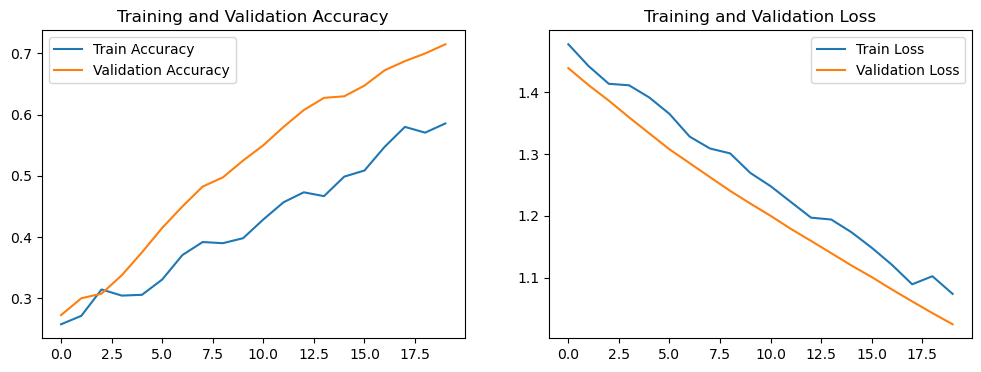

In [62]:
# Plot accuracy and loss
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(20)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.show()


In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

model.save("disaster_classifier.h5")
print("Model saved as disaster_classifier.h5")


# Load trained model
model = tf.keras.models.load_model("disaster_classifier.h5")  # Ensure correct model name

Model saved as disaster_classifier.h5


# experimentation and output

1/1 [==============================] - 0s 53ms/step


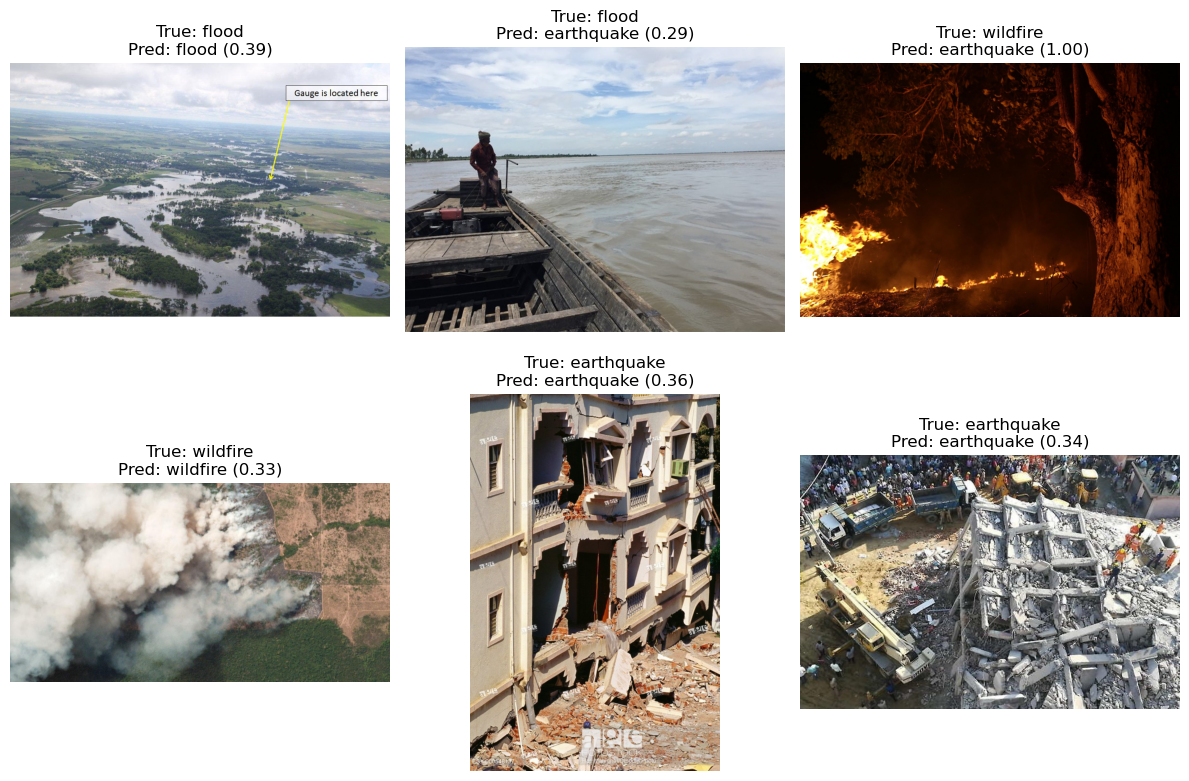

In [82]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Folder containing test images (Adjust path)
test_folder = "/Users/rohanshenoy/Desktop/DisasterModel/test"

# Function to preprocess images
def preprocess_image(img_path):
    """Load, resize, normalize, and add batch dimension."""
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Ensures same preprocessing as training
    return img_array

# Choose 6 random test images
sample_images = []
true_labels = []

for class_name in os.listdir(test_folder):  
    class_folder = os.path.join(test_folder, class_name)
    if os.path.isdir(class_folder):
        images = os.listdir(class_folder)
        selected_images = random.sample(images, 2)  # Pick 2 per class
        sample_images += [os.path.join(class_folder, img) for img in selected_images]
        true_labels += [class_name] * 2  # Store actual labels

# Plot predictions for 6 images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    img_path = sample_images[i]
    img_array = preprocess_image(img_path)  # Preprocess
    predictions = model.predict(img_array)
    
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    true_class = true_labels[i]

    # Display image + prediction
    ax.imshow(image.load_img(img_path))
    ax.set_title(f"True: {true_class}\nPred: {predicted_class} ({confidence:.2f})")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [83]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Final Test Accuracy: {test_acc:.4f}")


13/13 [==============================] - 20s 1s/step - loss: 1.0082 - accuracy: 0.7250
Final Test Accuracy: 0.7250


In [84]:
for img, label in test_dataset.take(1):  
    preds = model.predict(img)  
    print("Raw Predictions:", preds[0])  
    print("Predicted Class:", np.argmax(preds[0]), "True Class:", label.numpy()[0])


1/1 [==============================] - 1s 1s/step
Raw Predictions: [0.22509459 0.1596104  0.22747467 0.38782024]
Predicted Class: 3 True Class: 3


# random debugging and checking for errors

In [85]:
for images, labels in train_dataset.take(1):
    print("Sample Labels:", labels.numpy())  # Check labels are distributed correctly


2025-03-25 20:12:56.247781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:777: Filling up shuffle buffer (this may take a while): 24 of 1000


Sample Labels: [2 0 0 0 1 2 2 3 1 1 0 1 1 0 0 0 0 1 2 3 3 1 1 0 2 2 3 2 1 2 1 0]


2025-03-25 20:13:03.189448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


In [88]:
for img, label in test_dataset.take(1):  
    manual_img = preprocess_image(sample_images[0])  # Preprocess manually loaded image
    
    test_pred = model.predict(img)[0]  # Prediction from test dataset
    manual_pred = model.predict(manual_img)[0]  # Prediction from manually loaded image
    
    print("Test dataset prediction:", test_pred)
    print("Predicted Class:", np.argmax(test_pred), "| True Class:", label.numpy()[0])
    
    print("\nManual image prediction:", manual_pred)
    print("Predicted Class:", np.argmax(manual_pred), "| Actual Class (from filename):", sample_images[0].split('/')[-2])


1/1 [==============================] - 0s 67ms/step
Test dataset prediction: [0.16540255 0.22525354 0.13623893 0.473105  ]
Predicted Class: 3 | True Class: 3

Manual image prediction: [0.2451774  0.1721601  0.38765416 0.19500831]
Predicted Class: 2 | Actual Class (from filename): flood


In [89]:
print("Test dataset shape:", img.shape)
print("Manual image shape:", preprocess_image(sample_images[0]).shape)


Test dataset shape: (32, 224, 224, 3)
Manual image shape: (1, 224, 224, 3)
